In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

### 数据集读取
- Mnist数据是图像数据：(28,28,1)的灰度图

In [6]:
from sklearn.datasets import fetch_openml
import os

# 确保 data 文件夹存在
data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

# 下载 MNIST 数据集并保存到 data 文件夹中
mnist = fetch_openml("mnist_784", parser='auto', data_home=data_dir)

# 打印数据集信息
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [10]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [11]:
y.shape

(70000,)

![title](./img/数据集.png)

In [16]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [17]:
# 洗牌操作
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train.iloc[shuffle_index], y_train.iloc[shuffle_index]

In [18]:
shuffle_index

array([30236,  2356,  1029, ..., 15651,  3401, 37328])

### 交叉验证

![title](./img/机器学习中的数据集划分与交叉验证.png)

![title](./img/K折交叉验证流程示意图.png)

In [34]:
y_train_5 = (y_train=='1')
y_test_5 = (y_test=='1')

In [35]:
y_train_5[:10]

30236    False
2356      True
1029     False
24073    False
8867     False
22304    False
55063    False
58031    False
32698    False
36614    False
Name: class, dtype: bool

In [36]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=5,random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(max_iter=5, random_state=42)

In [37]:
sgd_clf.predict([X.iloc[35000]])

array([ True])

In [38]:
y[35000]

'1'

In [39]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring='accuracy')

array([0.98195, 0.97025, 0.98905])

In [40]:
X_train.shape

(60000, 784)

In [41]:
y_train_5.shape

(60000,)

In [49]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skflods = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 设置 shuffle=True
for train_index, test_index in skflods.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train.iloc[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.83195
0.82785
0.86935


### Confusion Matrix-混淆矩阵

![title](./img/Problem.png)

In [50]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [51]:
y_train_pred.shape

(60000,)

In [52]:
X_train.shape

(60000, 784)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[52779,   479],
       [  696,  6046]], dtype=int64)

negative class  [[ **true negatives** , **false positives** ],
 
positive class  [ **false negatives** , **true positives** ]]

* true negatives:  53,272个数据被正确的分为非5类别
* false positives：1307张被错误的分为5类别

* false negatives：1077张错误的分为非5类别
* true positives： 4344张被正确的分为5类别

一个完美的分类器应该只有**true positives** 和 **true negatives**, 即主对角线元素不为0，其余元素为0

### Precision and Recall


### **$ precision = \frac {TP} {TP + FP} $**


### **$ recall = \frac {TP} {TP + FN} $**

![title](./img/混淆矩阵与分类性能指标示例.png)

In [54]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.9265900383141762

In [55]:
recall_score(y_train_5,y_train_pred)

0.8967665381192524

将**Precision** 和 **Recall**结合到一个称为**F1 score** 的指标,调和平均值给予低值更多权重。 因此，如果召回和精确度都很高，分类器将获得高F 1分数。

### $ F_1  = $ $2\over {1\over precision}+{1\over recall} $ $=$ $2×$ $precision×recall\over precision+recall $ $=$ $TP\over {TP}+{FN + FP\over 2}$

In [56]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.9114343860707017

### 阈值对结果的影响

![title](./img/不同阈值下的精确率和召回率变化示例.png)

In [58]:
y_scores = sgd_clf.decision_function([X.iloc[35000]])
y_scores

array([233294.38935857])

In [59]:
t = 50000
y_pred = (y_scores > t)
y_pred

array([ True])

Scikit-Learn不允许直接设置阈值，但它可以得到决策分数，调用其**decision_function（）**方法，而不是调用分类器的**predict（）**方法，该方法返回每个实例的分数，然后使用想要的**阈值**根据这些分数进行预测：

In [60]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [61]:
y_scores[:10]

array([-869196.80667489,   19844.53183921, -775010.2684334 ,
       -214543.49994203,  -52699.41116547, -990628.2068311 ,
       -913270.11052216, -601808.85947117, -904491.16137316,
       -756041.91535701])

In [62]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [63]:
y_train_5.shape

(60000,)

In [64]:
thresholds.shape

(60000,)

In [65]:
precisions[:10]

array([0.11236667, 0.11236854, 0.11237041, 0.11237229, 0.11237416,
       0.11237603, 0.1123779 , 0.11237978, 0.11238165, 0.11238352])

In [66]:
precisions.shape

(60001,)

In [67]:
recalls.shape

(60001,)

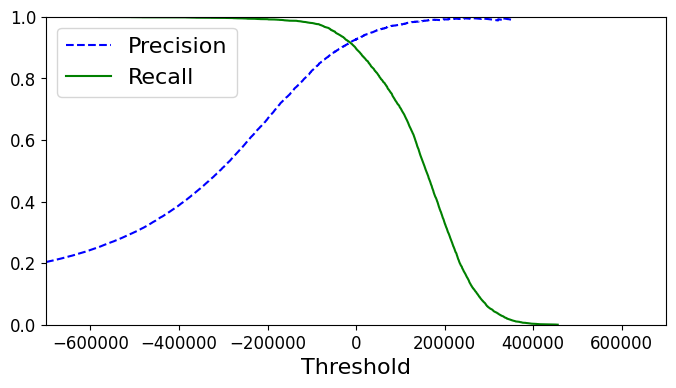

In [68]:
def plot_precision_recall_vs_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,
             precisions[:-1],
            "b--",
            label="Precision")
    
    plt.plot(thresholds,
             recalls[:-1],
            "g-",
            label="Recall")
    plt.xlabel("Threshold",fontsize=16)
    plt.legend(loc="upper left",fontsize=16)
    plt.ylim([0,1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.xlim([-700000, 700000])
plt.show()

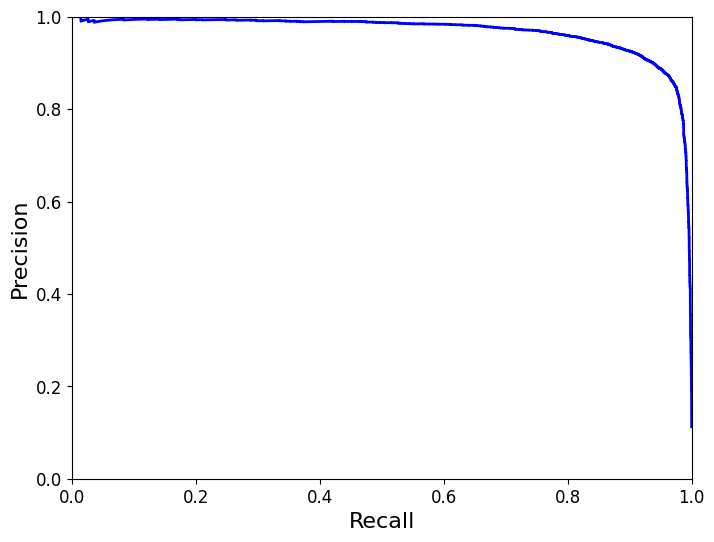

In [69]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, 
             precisions, 
             "b-", 
             linewidth=2)
    
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### ROC curves
**receiver operating characteristic (ROC)** 曲线是二元分类中的常用评估方法
* 它与精确度/召回曲线非常相似，但ROC曲线不是绘制精确度与召回率，而是绘制**true positive rate(TPR)** 与**false positive rate(FPR)** 

* 要绘制ROC曲线，首先需要使用**roc_curve（）**函数计算各种阈值的**TPR和FPR**：

TPR = TP / (TP + FN) (Recall)

FPR = FP / (FP + TN)

In [70]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

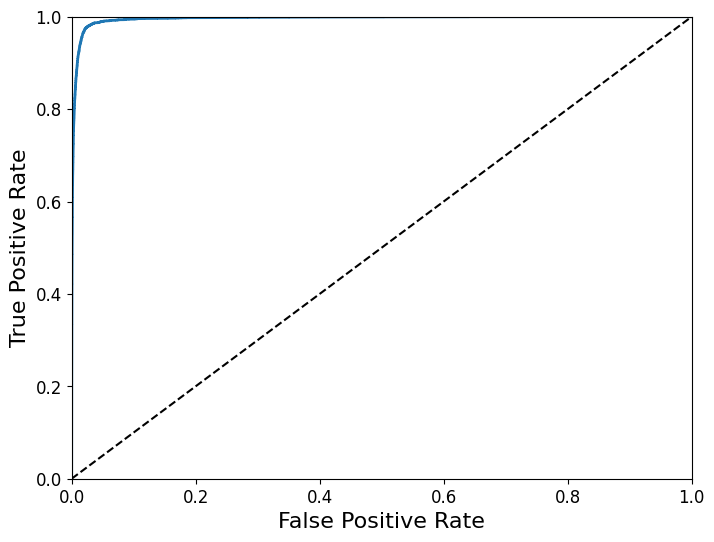

In [71]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

**虚线表示纯随机分类器的ROC曲线**; 一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下面积（AUC）。完美分类器的ROC AUC**等于1**，而纯随机分类器的ROC AUC**等于0.5**。 Scikit-Learn提供了计算ROC AUC的函数：

In [72]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9955639896233288